In [1]:
import os
import pickle
import numpy as np
from scipy import interp
import matplotlib
# matplotlib.use('Agg')
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.svm import SVC

In [2]:
CHANNELS = ['Fp1', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'FC5', 'FCz', 'FC6', 'T7', 'C3', 'Cz', 'C4',
            'T8', 'CP5', 'CP1', 'CP2', 'CP6', 'P7', 'P3', 'Pz', 'P4', 'P8', 'O1', 'O2']

Define method for grid search with different classification methods to find their optimal parameters

In [3]:
def perform_logistic_regression(X, y, n_splits, score):
    # Grid search with logistic regression
    lr = LogisticRegression(C=1.0)

    # GridSearch for liblinear solver
    C_range = [0.1, 1, 10, 100, 1000, 10000]
    penalty_options = ['l1', 'l2']
    fit_intercept_options = [True, False]
    solver_option = ['liblinear']
    class_weight_option = ['auto', '']

    param_grid = dict(C=C_range, penalty=penalty_options, fit_intercept=fit_intercept_options, solver=solver_option)

    # solver_options = ['newton-cg', 'lbfgs', 'sag', 'saga']
    # multi_class_options = ['ovr', 'multinomial']
    # class_weight_options = [None, 'balanced']

    # param_grid = dict(solver = solver_options, multi_class = multi_class_options, class_weight = class_weight_options)

    best_params = perform_grid_search(lr, X, y, score, n_splits, param_grid, 'Logistic Regression')
    
    return best_params
    

def perform_lda(X, y, n_splits, score):
    lda = LinearDiscriminantAnalysis()

    solver_options = ['lsqr']
    #shrinkage_options = [None, 'auto']
    shrinkage = np.arange(0.0, 1.05, 0.05)
    
    param_grid = dict(solver=solver_options, shrinkage=shrinkage)

    best_params = perform_grid_search(lda, X, y, score, n_splits, param_grid, 'LDA')
    
    return best_params
    

def perform_svc(X, y, n_splits, score):
    svc = SVC()
    
    param_grid = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                         'C': [1, 10, 100, 1000]},
                        {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]

    
    best_params = perform_grid_search(svc, X, y, score, n_splits, param_grid, 'SVC')
    
    return best_params

    
def perform_grid_search(clf, X, y, score, n_splits, param_grid, name, verbose=False):
    
    cv = StratifiedKFold(n_splits=10)
    
    grid_clf = GridSearchCV(clf, param_grid, cv=cv, scoring=score)
    grid_clf.fit(X, y)
    
    if verbose:
        print("# Tuning parameters for %s" % name)
        print()
        # best results
        print("The best parameters are %s with a score of %0.2f" \
              % (grid_clf.best_params_, grid_clf.best_score_))
        print()
        # complete results
        means = grid_clf.cv_results_['mean_test_score']
        stds = grid_clf.cv_results_['std_test_score']
        for mean, std, params in zip(means, stds, grid_clf.cv_results_['params']):
            print("%0.3f (+/-%0.03f) for %r"
                  % (mean, std * 2, params))
        print("\n")
    
    return grid_clf.best_params_

In [4]:
def run_evaluation(clf, X, y, n_splits, score='accuracy', pos_label=1, ax=plt, title='ROC', measure='acc'):
    
    results = []
    
    # Variables for ROC analysis
    grand_mean_tpr = 0.0
    grand_mean_fpr = np.linspace(0, 1, 100)
    
    i = 0
    for iteration in range(0, 10):
        
        cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=iteration)

        # Variable for accuracy score
        mean_score = 0
        
        # Variables for ROC analysis
        mean_tpr = 0
        mean_fpr = np.linspace(0, 1, 100)
        
        j = 0
        for train, test in cv.split(X, y):
            
            # Compute accuracy score
            y_pred = clf.fit(X[train], y[train]).predict(X[test])
            
            # Compute probas for ROC computation
            probas_ = clf.fit(X[train], y[train]).predict_proba(X[test])
            
            # Compute ROC curve and area the curve
            fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
            mean_tpr += interp(mean_fpr, fpr, tpr)
            mean_tpr[0] = 0.0
            
            grand_mean_tpr += interp(mean_fpr, fpr, tpr)
            grand_mean_fpr[0] = 0.0
            
            if score is 'accuracy':
                mean_score += accuracy_score(y[test], y_pred)
            elif score is 'precision':
                mean_score += precision_score(y[test], y_pred, pos_label=pos_label)
            elif score is 'recall':
                mean_score += recall_score(y[test], y_pred, pos_label=pos_label)

            j += 1
        
        # Mean ROC
        mean_tpr /= j
        mean_tpr[-1] = 1.0
        mean_auc = auc(mean_fpr, mean_tpr)
        
        i += 1
        
        # Plot ROC curve for iteration 
        ax.plot(mean_fpr, mean_tpr,
                label='Iteration %d / AUC = %0.2f' % (i, mean_auc), lw=0.5)
        
        # Mean accuracy
        mean_score /= n_splits
        
        if measure is 'acc':
            results.append(mean_score)
        elif measure is 'roc':
            results.append(mean_auc)
    
    # Grand Mean ROC for ROC curve plot
    grand_mean_tpr /= j * i
    grand_mean_fpr[-1] = 1.0
    grand_mean_auc = auc(grand_mean_fpr, grand_mean_tpr)
    
    # Plot Grand ROC curve
    ax.plot(grand_mean_fpr, grand_mean_tpr,
                 label='Mean' + ' / AUC = %0.2f' % grand_mean_auc, lw=3)
    ax.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Chance')
    ax.set_title(title)
    ax.legend(loc="lower right", prop={'size':8})
        
    return results

In [12]:
def run_set_of_evaluations(datasets, n_splits, optimize_score, evaluate_scores, pos_label, name):
    
    # initialize result dictionary and lists for each score
    results = {}
    
    for score in evaluate_scores:
        results[score] = []
    
    # prepare ROC plots
    fig, ax = plt.subplots(len(datasets), 2, figsize=(len(datasets)*4, len(datasets)*5.33), sharex=True, sharey=True)
    
    # evaluate each dataset
    i = 0
    for dataset in datasets:
        
        X, y = dataset.get_features_and_labels('Consc_Group')
        
        # parameter optimization
        best_params_lda = perform_lda(X, y, n_splits, optimize_score)
        best_params_lr = perform_logistic_regression(X, y, n_splits, optimize_score)
        
        print(dataset.description)
        print("LDA: " + str(best_params_lda))
        print("LR: " + str(best_params_lr))
        
        lda = LinearDiscriminantAnalysis(**best_params_lda)
        lr = LogisticRegression(**best_params_lr)
        
        # evaluate best parameters on each score
        for score in evaluate_scores:
            
            results_dataset = []

            results_lda = run_evaluation(lda, X, y, n_splits, score, pos_label, ax[i,0], measure='acc',
                                         title=dataset.description + ': Linear Discriminant Analysis')
            results_lr = run_evaluation(lr, X, y, n_splits, score, pos_label, ax[i,1], measure='acc',
                                        title=dataset.description + ': Logistic Regression')

            results_dataset.append(results_lda)
            results_dataset.append(results_lr)

            results[score].append(results_dataset)
        
        i += 1

    # result presentation
    
    # make plots - ROC
    ax[len(datasets)-1, 0].set_xlabel('False Positive Rate')
    ax[len(datasets)-1, 1].set_xlabel('False Positive Rate')
    
    for i in range(0, len(datasets)):
        ax[i,0].set_ylabel('True Positive Rate')
    
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plot_path = os.path.abspath(os.path.join(image_directory, 'roc_comparison_lr_lda.png'))
    plt.savefig(plot_path, dpi=300, bbox_inches='tight')
    plt.show()
    
    xtick_labels = []
    
    for dataset in datasets:
        xtick_labels.append(dataset.description)
    
    for score in evaluate_scores:
        
        results[score] = np.array(results[score])
        
        means = np.mean(results[score], axis=2)
        stds = np.std(results[score], axis=2)

        print('Folds: %i\nOptimized: %s\nScore: %s' % (n_splits, optimize_score, score))
        print(means[:,0])
        print(means[:,1])
        
        print(stds[:,0])
        print(stds[:,1])
        
        ind = np.arange(len(means))
        width = 0.35

        fig, ax = plt.subplots()
        rects1 = ax.bar(ind - width/2, means[:,0], width, yerr=stds[:,0], color='CornFlowerBlue', label='LDA', capsize=5)
        rects2 = ax.bar(ind + width/2, means[:,1], width, yerr=stds[:,1], color='Crimson', label='LR', capsize=5)

        ax.set_ylabel(score.title())
        # ax.set_title('%s by instruction condition and classifier' % score)
        ax.set_xticks(ind)
        ax.set_xticklabels(xtick_labels)
        ax.legend()

        plot_path = os.path.abspath(os.path.join(image_directory, name + '_' + score + '_lr_lda.png'))
        
        plt.ylim([0, 0.85])
        plt.savefig(plot_path, dpi=300, bbox_inches='tight')
        
    return results
    

### Evaluation of IntErr2 data

Set important directories.

In [6]:
working_directory = 'L:/int_err2'
current_path = os.path.abspath(working_directory)
image_directory = os.path.abspath(os.path.join(current_path, 'images'))
pickle_directory = os.path.abspath(os.path.join(current_path, 'pickles'))
data_directory = os.path.abspath(os.path.join(current_path, 'data'))

Load separability indices.

In [7]:
std_comp_corr_file = os.path.abspath(os.path.join(pickle_directory, 'std_comp_corr.pkl'))
with open(std_comp_corr_file, 'rb') as pickle_file:
    std_comp_corr = pickle.load(pickle_file)
    
std_incomp_corr_file = os.path.abspath(os.path.join(pickle_directory, 'std_incomp_corr.pkl'))
with open(std_incomp_corr_file, 'rb') as pickle_file:
    std_incomp_corr = pickle.load(pickle_file)
    
alt_comp_corr_file = os.path.abspath(os.path.join(pickle_directory, 'alt_comp_corr.pkl'))
with open(alt_comp_corr_file, 'rb') as pickle_file:
    alt_comp_corr = pickle.load(pickle_file)
    
alt_incomp_corr_file = os.path.abspath(os.path.join(pickle_directory, 'alt_incomp_corr.pkl'))
with open(alt_incomp_corr_file, 'rb') as pickle_file:
    alt_incomp_corr = pickle.load(pickle_file)

In [8]:
std_comp_corr.extract_features([[112, 152]], CHANNELS, 'Consc_Group')
std_incomp_corr.extract_features([[112, 148]], CHANNELS, 'Consc_Group')
alt_comp_corr.extract_features([[112, 152], [468, 484]], CHANNELS, 'Consc_Group')
alt_incomp_corr.extract_features([[348, 380]], CHANNELS, 'Consc_Group')
# alt_incomp_corr.extract_features([[-20, 0], [348, 380]], CHANNELS, 'Consc_Group')

std_comp_corr.description = 'STD (congruent)'
std_incomp_corr.description = 'STD (incongruent)'
alt_comp_corr.description = 'ALT (congruent)'
alt_incomp_corr.description = 'ALT (incongruent)'

STD (congruent)
LDA: {'shrinkage': 0.25, 'solver': 'lsqr'}
LR: {'C': 0.1, 'fit_intercept': True, 'penalty': 'l1', 'solver': 'liblinear'}
STD (incongruent)
LDA: {'shrinkage': 0.55, 'solver': 'lsqr'}
LR: {'C': 0.1, 'fit_intercept': True, 'penalty': 'l1', 'solver': 'liblinear'}
ALT (congruent)
LDA: {'shrinkage': 1.0, 'solver': 'lsqr'}
LR: {'C': 0.1, 'fit_intercept': True, 'penalty': 'l1', 'solver': 'liblinear'}
ALT (incongruent)
LDA: {'shrinkage': 0.5, 'solver': 'lsqr'}
LR: {'C': 1000, 'fit_intercept': True, 'penalty': 'l1', 'solver': 'liblinear'}


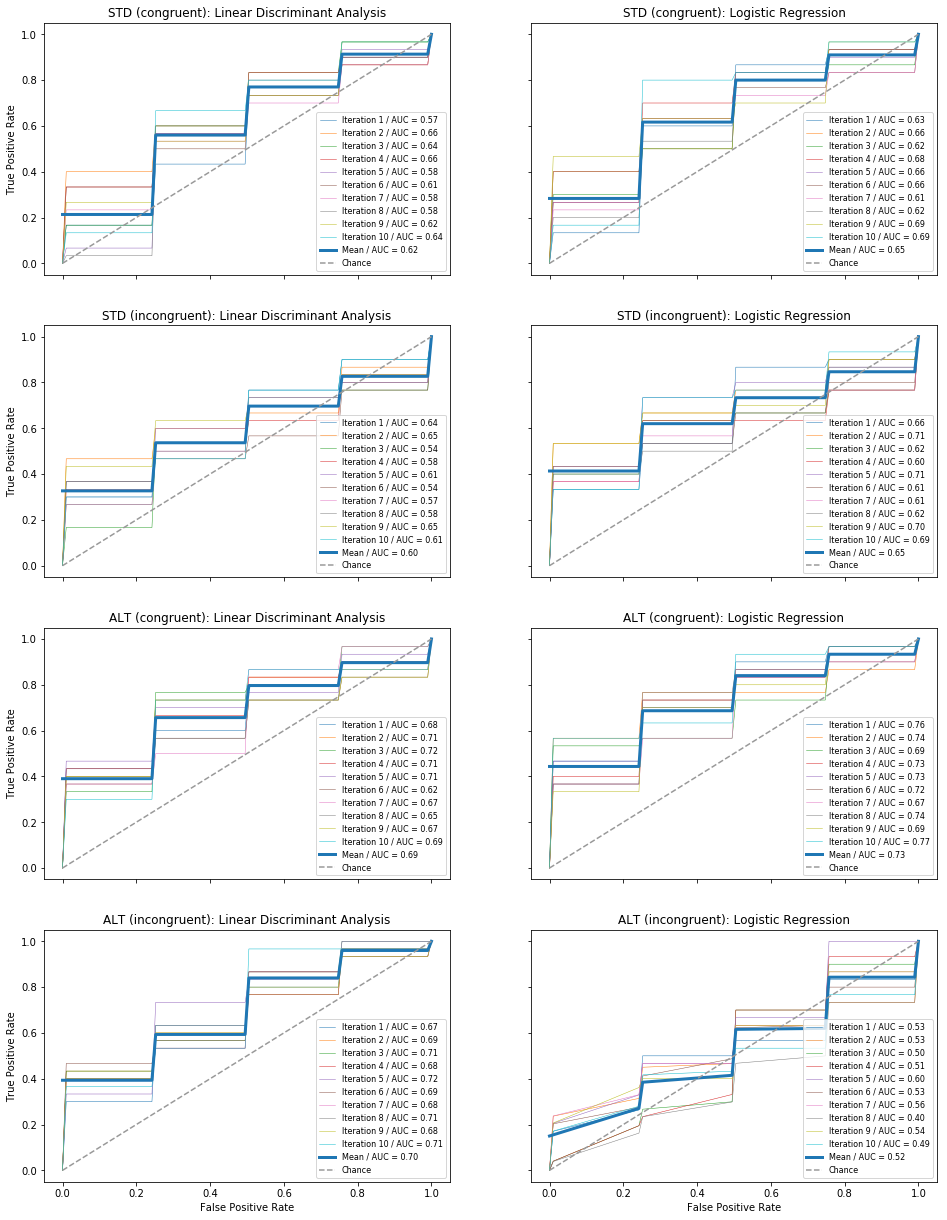

Folds: 6
Optimized: accuracy
Score: accuracy
[0.65740741 0.59814815 0.65925926 0.60925926]
[0.65740741 0.54444444 0.68703704 0.53333333]
[0.03906486 0.04539871 0.02644973 0.02103299]
[0.02378747 0.02511974 0.05135342 0.04955218]


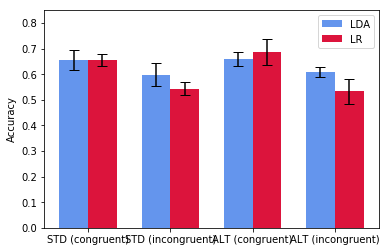

In [13]:
results_ie2 = run_set_of_evaluations([std_comp_corr, std_incomp_corr, alt_comp_corr, alt_incomp_corr], 6, 'accuracy', ['accuracy'], 1, 'interr2')

In [13]:
print(np.round(results_ie2['accuracy'], 2))

eval_file_ie2 = os.path.abspath(os.path.join(data_directory, 'results_6_acc.csv'))

with open(eval_file_ie2, 'wb') as file:
    for dataset in results_ie2['accuracy']:
        np.savetxt(file, dataset, delimiter=",")


[[[0.59 0.7  0.67 0.65 0.63 0.69 0.59 0.67 0.69 0.7 ]
  [0.67 0.63 0.63 0.65 0.63 0.69 0.65 0.67 0.7  0.67]]

 [[0.59 0.67 0.5  0.59 0.57 0.56 0.63 0.61 0.61 0.65]
  [0.54 0.56 0.5  0.54 0.57 0.57 0.56 0.52 0.57 0.52]]

 [[0.61 0.69 0.67 0.67 0.67 0.61 0.69 0.67 0.65 0.69]
  [0.74 0.61 0.76 0.67 0.7  0.72 0.61 0.67 0.65 0.74]]

 [[0.57 0.61 0.63 0.63 0.59 0.63 0.61 0.61 0.57 0.63]
  [0.57 0.48 0.54 0.54 0.61 0.56 0.52 0.44 0.57 0.48]]]


### Evaluation of IntErr1 data

Set important directories.

In [93]:
working_directory = 'L:/int_err'
current_path = os.path.abspath(working_directory)
image_directory = os.path.abspath(os.path.join(current_path, 'images'))
pickle_directory = os.path.abspath(os.path.join(current_path, 'pickles'))
data_directory = os.path.abspath(os.path.join(current_path, 'data'))

Load separability indices.

In [75]:
consc_std_corr_file = os.path.abspath(os.path.join(pickle_directory, 'consc_std_corr.pkl'))
with open(consc_std_corr_file, 'rb') as pickle_file:
    consc_std_corr = pickle.load(pickle_file)
    
consc_rv_corr_file = os.path.abspath(os.path.join(pickle_directory, 'consc_rv_corr.pkl'))
with open(consc_rv_corr_file, 'rb') as pickle_file:
    consc_rv_corr = pickle.load(pickle_file)  

consc_rr_corr_file = os.path.abspath(os.path.join(pickle_directory, 'consc_rr_corr.pkl'))
with open(consc_rr_corr_file, 'rb') as pickle_file:
    consc_rr_corr = pickle.load(pickle_file)  

In [76]:
consc_std_corr.extract_features([[124, 188], [192, 212]], CHANNELS, 'Consc_Group')
# A: [160, 180], [204, 240] - B: [120, 192], [200, 220] - C: [246, 278]
consc_rv_corr.extract_features([[120, 192], [200, 220]], CHANNELS, 'Consc_Group')
# A: [160, 180], [204, 240] - B: [112, 168], [172, 212]
consc_rr_corr.extract_features([[112, 220]], CHANNELS, 'Consc_Group')
# A: [112, 168], [172, 212]

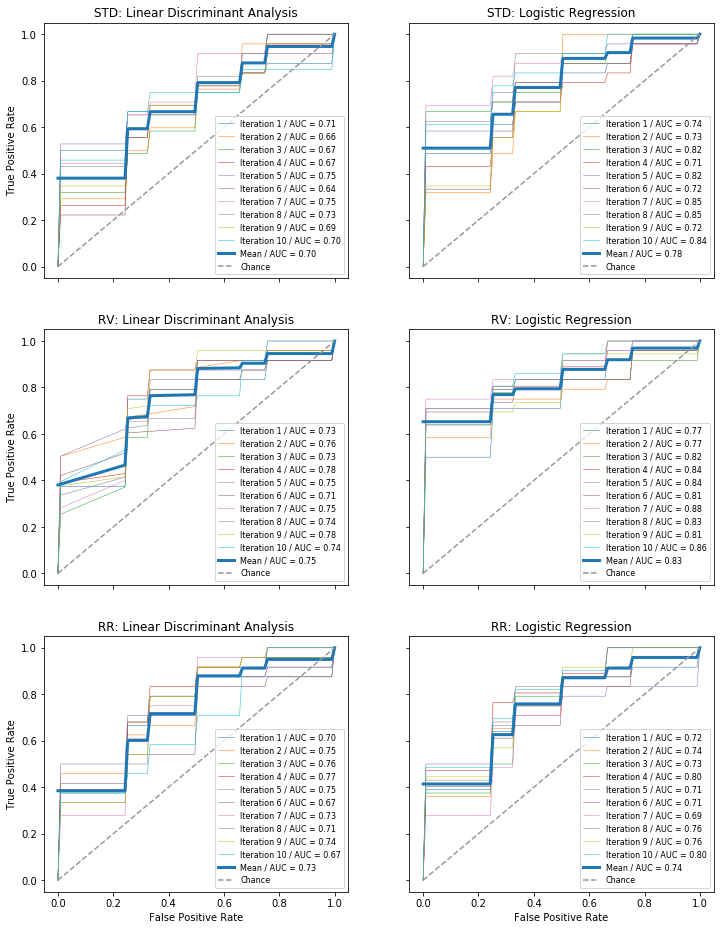

Folds: 6
Optimized: accuracy
Score: accuracy
[0.69695567 0.74825422 0.72532267]
[0.78083614 0.82236251 0.74224186]
[0.03580199 0.02221748 0.03432522]
[0.0563907  0.03263006 0.03554392]


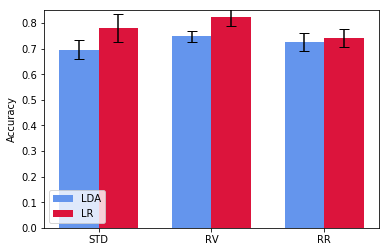

In [92]:
results_ie1 = run_set_of_evaluations([consc_std_corr, consc_rv_corr, consc_rr_corr], 6, 'accuracy', ['accuracy'], 2, 'interr1')

In [96]:
print(np.round(results_ie1['accuracy'], 2))

eval_file_ie1 = os.path.abspath(os.path.join(data_directory, 'results_6_roc_auc.csv'))

with open(eval_file_ie1, 'wb') as file:
    for dataset in results_ie1['accuracy']:
        np.savetxt(file, dataset, delimiter=",")

[[[0.71 0.66 0.67 0.67 0.75 0.64 0.75 0.73 0.69 0.7 ]
  [0.74 0.73 0.82 0.71 0.82 0.72 0.85 0.85 0.72 0.84]]

 [[0.73 0.76 0.73 0.78 0.75 0.71 0.75 0.74 0.78 0.74]
  [0.77 0.77 0.82 0.84 0.84 0.81 0.88 0.83 0.81 0.86]]

 [[0.7  0.75 0.76 0.77 0.75 0.67 0.73 0.71 0.74 0.67]
  [0.72 0.74 0.73 0.8  0.71 0.71 0.69 0.76 0.76 0.8 ]]]
